In [2]:
import json # we need to use the JSON package to load the data, since the data is stored in JSON format
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
# Lowercase the text and split by whitespace
def preprocess_simple(data):
    data1 = data.copy()
    for data_point in data1:
        data_point["text"] = data_point["text"].lower().split()
    return data1

In [4]:
# Preprocessing using nltk package, tokenize, lemmatize, and remove unrelevant symbol
def preprocess_new_feature(data):
    data1 = data.copy()
    wordnet_lemmatizer = WordNetLemmatizer()
    for data_point in data:
        data_point["text"] = word_tokenize(data_point["text"])
        data_point["text"] = [w.lower() for w in data_point["text"]]
        data_point["text"] = [wordnet_lemmatizer.lemmatize(w) for w in data_point["text"]]
        data_point["text"] = [w for w in data_point["text"] if not w in ['.', ',', "'", '"', "?", "!", "[", "]", '(', ')', '-', '...'
           , "''", '``',":", " "]]
    return data1

# Split data to training, validation and testing sets.
def split_data(data):
    train_data = data[:10000]
    val_data = data[10000:11000]
    test_data = data[11000:]
    return train_data, val_data, test_data

# Return words count matrix
# num specify top-n words count return
def words_count(data, num=60):
    words_recurrence = {}
    for data_point in data:
        for word in data_point["text"]:
            if word in words_recurrence:
                words_recurrence[word] += 1
            else:
                words_recurrence[word] = 1
    words_recurrence = sorted(words_recurrence.items(), key=lambda kv: kv[1], reverse=True)
    words_recurrence = words_recurrence[:num]
    return words_recurrence

# Get feature matrix given data.
# Num specify the number of points.
def feature_extraction(data, num, words_recurrence):
    w = {}
    i = 0
    for word in words_recurrence:
        w[word[0]] = i
        i += 1
    feature_num = len(words_recurrence)
    x = np.zeros((num, feature_num))
    i = 0
    for data_point in data:
        for word in data_point["text"]:
            if word in w:
                x[i, w[word]] += 1
        i += 1
    return x;

# Add bias term to the data matrix
def add_bias(matrix):
    x_dataset_bias = np.ones((matrix.shape[0], matrix.shape[1]+1))
    x_dataset_bias[:,:-1] = matrix
    return x_dataset_bias

# Calculate the mean square error
def mse(predict, true):
    return (np.square(predict - true).mean(axis=None))

In [5]:
with open("proj1_data.json") as fp:
    data = json.load(fp)
data_processed = preprocess_simple(data)

# split data
train_data, val_data, test_data = split_data(data_processed)
words_top160 = words_count(train_data, num=160)
words_list = []
for word in words_top160:
    words_list.append(word[0])
words_list

['the',
 'i',
 'a',
 'to',
 'and',
 'of',
 'you',
 'that',
 'in',
 'it',
 'was',
 'is',
 'my',
 'for',
 'have',
 'but',
 'this',
 'with',
 'on',
 'not',
 'be',
 'just',
 'or',
 'if',
 'they',
 'your',
 'so',
 'like',
 'are',
 'at',
 'me',
 'as',
 'he',
 "it's",
 'she',
 "i'm",
 'about',
 'when',
 'we',
 'all',
 'because',
 'from',
 'her',
 'out',
 'would',
 'get',
 "don't",
 'had',
 'what',
 'one',
 'up',
 'people',
 'can',
 'an',
 'do',
 '[deleted]',
 'some',
 'how',
 'any',
 'really',
 'his',
 'then',
 'think',
 'no',
 'more',
 'there',
 'their',
 'who',
 'were',
 'will',
 'it.',
 'them',
 'by',
 'has',
 'only',
 'time',
 'go',
 'know',
 'even',
 'got',
 'been',
 'good',
 'new',
 'after',
 "you're",
 'never',
 'please',
 'make',
 'than',
 'am',
 'still',
 "that's",
 'him',
 'did',
 'being',
 'into',
 'much',
 "didn't",
 'other',
 'something',
 'going',
 'could',
 'post',
 'first',
 'way',
 'where',
 'also',
 'want',
 'over',
 '-',
 'most',
 "can't",
 'say',
 'see',
 'pretty',
 'why',

In [6]:
def closed_form(X, y):
    #return np.linalg.inv(np.transpose(X) @ X) @ np.transpose(X) @ y
    return np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X), X)), np.transpose(X)), y)

In [7]:
def gradient_descent(X, y, beta, n0, eps, show=False):
    i = 1
    weight = np.random.rand(X.shape[1])
    a1 = np.transpose(X) @ X
    a2 = np.transpose(X) @ y
    while True:
        alpha = n0/((1+beta*i) * 10000)
        weight_new = weight - 2*alpha * (a1@weight - a2)
        difference = np.linalg.norm(weight_new - weight, ord=2)
        weight = weight_new
        i += 1   
        if show:
            if(i % 1000 == 0):
                print("Iteration: " + str(i) + ". Difference: " + str(difference))
        if (difference < eps):
            break
    return weight

In [8]:
with open("proj1_data.json") as fp:
    data = json.load(fp)
data_processed = preprocess_simple(data)

# split data
train_data, val_data, test_data = split_data(data_processed)
words_top160 = words_count(train_data, num=160)
train_x_160 = add_bias(feature_extraction(train_data, 10000, words_top160))
val_x_160 = add_bias(feature_extraction(val_data, 1000, words_top160))
test_x_160 = add_bias(feature_extraction(test_data, 1000, words_top160))

In [9]:
with open("proj1_data.json") as fp:
    data = json.load(fp)
data_processed = preprocess_simple(data)

# split data
train_data, val_data, test_data = split_data(data_processed)
words_top60 = words_count(train_data, num=60)

train_x_60 = add_bias(feature_extraction(train_data, 10000, words_top60))

val_x_60 = add_bias(feature_extraction(val_data, 1000, words_top60))
test_x_60 = add_bias(feature_extraction(test_data, 1000, words_top60))

In [10]:
with open("proj1_data.json") as fp:
    data = json.load(fp)
x_3 = np.zeros((12000, 3))
i=0
for data_point in data:
    if data_point["is_root"]:
        x_3[i, 0] = 1
    else:
        x_3[i, 0] = 0
    x_3[i, 1] = data_point["controversiality"]
    x_3[i, 2] = data_point["children"]
    i = i + 1
train_x_3 = x_3[:10000]
val_x_3 = x_3[10000:11000]
test_x_3 = x_3[11000:]
train_x_3 = add_bias(train_x_3)
val_x_3 = add_bias(val_x_3)
test_x_3 = add_bias(test_x_3)

In [11]:
with open("proj1_data.json") as fp:
    data = json.load(fp)
y = np.zeros(12000)
i = 0
for data_point in data:
    y[i] = data_point["popularity_score"]
    i += 1
y_train = y[:10000]
y_val = y[10000:11000]
y_test = y[11000:]

In [12]:
start = timeit.default_timer()
weights_cf = closed_form(train_x_3, y_train)
end = timeit.default_timer()
run_time_cf = end - start
print(run_time_cf)
start = timeit.default_timer()
weights_gd = gradient_descent(train_x_3, y_train, beta=10e-3, n0=10e-3, eps= 1 * 10e-07, show=True)
end = timeit.default_timer()
run_time_gd = end - start
print(run_time_gd)

0.07162282666666667
Iteration: 1000. Difference: 0.0001581256076247615
Iteration: 2000. Difference: 6.45759604312241e-05
Iteration: 3000. Difference: 3.7732354302592944e-05
Iteration: 4000. Difference: 2.568482886681978e-05
Iteration: 5000. Difference: 1.903760018885079e-05
Iteration: 6000. Difference: 1.4899067161867338e-05
Iteration: 7000. Difference: 1.2108717061725281e-05
Iteration: 8000. Difference: 1.011774577252023e-05
Iteration: 9000. Difference: 8.63567520085222e-06
Iteration: 10000. Difference: 7.495524640232397e-06
Iteration: 11000. Difference: 6.595035179894873e-06
Iteration: 12000. Difference: 5.868364398773198e-06
Iteration: 13000. Difference: 5.271355313154734e-06
Iteration: 14000. Difference: 4.773376987669639e-06
Iteration: 15000. Difference: 4.352567629865176e-06
Iteration: 16000. Difference: 3.992939774456634e-06
Iteration: 17000. Difference: 3.6825531932109087e-06
Iteration: 18000. Difference: 3.41232490007796e-06
Iteration: 19000. Difference: 3.175232604365139e-06


Run 5 times for closed form:
[-0.22627679 -1.08584747  0.37536403  0.82092517]
[-0.22627679 -1.08584747  0.37536403  0.82092517]
[-0.22627679 -1.08584747  0.37536403  0.82092517]
[-0.22627679 -1.08584747  0.37536403  0.82092517]
[-0.22627679 -1.08584747  0.37536403  0.82092517]


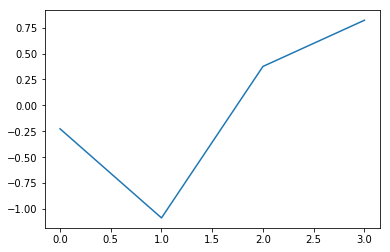

Run 5 times for gradient descent (same hyperparameter):
[-0.13975091  0.04509261  0.37641151  0.76219764]
[-0.1275707   0.60081539  0.37538463  0.74999551]
[-0.16583217  0.21279836  0.37459112  0.77484841]
[-0.14153582 -0.01564059  0.3764995   0.76378314]
[-0.14749312  0.03553719  0.37604697  0.76654164]


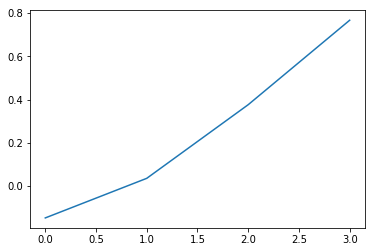

In [13]:
print("Run 5 times for closed form:")
for i in range(5):
    weights_cf = closed_form(train_x_3, y_train)
    print(weights_cf)
plt.plot(weights_cf)
plt.show()

print("Run 5 times for gradient descent (same hyperparameter):")
for i in range(5):
    weights_gd = gradient_descent(train_x_3, y_train, beta=10e-3, n0=10e-3, eps= 1 * 10e-07)
    print(weights_gd)
plt.plot(weights_gd)
plt.show()
    

    

1.2652963638167058


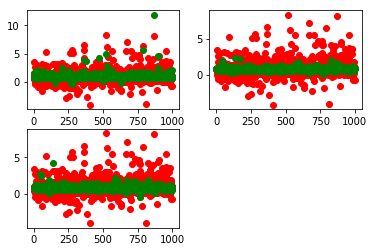

In [14]:
weights_3 = closed_form(train_x_3, y_train)
weights_60 = closed_form(train_x_60, y_train)
weights_160 = closed_form(train_x_160, y_train)
estimation_3_train = np.dot(val_x_3,weights_3)
estimation_3 = np.dot(val_x_3,weights_3)
estimation_60_train = np.dot(train_x_60,weights_60)
estimation_60 = np.dot(val_x_60,weights_60)
estimation_160_train = np.dot(train_x_160,weights_160)
estimation_160 = np.dot(val_x_160,weights_160)
plt.subplot(2,2,1)
plt.plot(y_val,'ro',estimation_3,'go')
plt.subplot(2,2,2)
plt.plot(y_val,'ro',estimation_60,'go')
plt.subplot(2,2,3)
plt.plot(y_val,'ro',estimation_160,'go')





mse_3_train = mse(np.dot(train_x_3, weights_3), y_train)
mse_3_val = mse(np.dot(val_x_3, weights_3), y_val)
mse_60_train = mse(np.dot(train_x_60, weights_60), y_train)
mse_60_val = mse(np.dot(val_x_60, weights_60), y_val)
print(mse_60_val)
mse_160_train = mse(np.dot(train_x_160, weights_160), y_train)
mse_160_val = mse(np.dot(val_x_160, weights_160), y_val)

In [25]:
def add_newfeature(x_matrix,data):
    x_new = np.zeros(12000)
    j = 0
    for data_point in data:
        x_new[j] = (data_point["children"]**2+data_point["controversiality"]**3)
        j += 1
    data1=np.append(x_matrix,x_new.reshape(12000,1),axis = 1)
    return(data1)

In [26]:
# Construct matrx x_feature2
x_f2_60 = feature_extraction(data_processed, 12000, words_top60)
x_f2 = add_bias(add_newfeature(x_f2_60, data))
# split x_feature2
x_f2_train = x_f2[:10000]
x_f2_val = x_f2[10000:11000]
x_f2_test = x_f2[11000:]

weight_f2_60 = closed_form(x_f2_train, y_train)
mse_60_f2_train = mse(np.dot(x_f2_train, weight_f2_60), y_train)
mse_60_f2_val = mse(np.dot(x_f2_val, weight_f2_60), y_val)
mse_60_f2_test = mse(np.dot(x_f2_test, weight_f2_60), y_test)

print("MSE for training sets with feature2:" + str(mse_60_f2_train))
print("MSE for validation sets with feature2:" + str(mse_60_f2_val))
print("MSE for test sets with feature2:" + str(mse_60_f2_test))

MSE for training sets with feature2:1.2556586306875666
MSE for validation sets with feature2:1.1632405973000193
MSE for test sets with feature2:1.5144807757399503


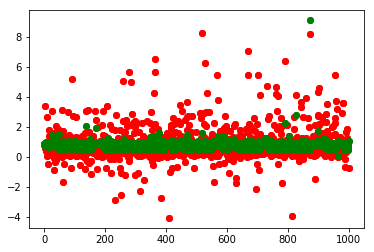

In [28]:

estimation_60_f2_train = np.dot(x_f2_train,weight_f2_60)
estimation_60_f2 = np.dot(x_f2_val,weight_f2_60)
plt.plot(y_val,'ro',estimation_60_f2,'go')
with open("/Users/inspur/Desktop/1.7/proj1_data.json") as fp:
    data = json.load(fp)
x_f = np.zeros((12000, 3))
i=0
for data_point in data:
    if data_point["is_root"]:
        x_f[i, 0] = 1
    else:
        x_f[i, 0] = 0
    x_f[i, 1] = data_point["controversiality"]
    x_f[i, 2] = data_point["children"]
    i = i + 1
x_f=add_bias(np.append(add_newfeature(x_f2_60, data),x_f.reshape(12000,3),axis = 1))

# split x_final
x_f_train = x_f[:10000]
x_f_val = x_f[10000:11000]
x_f_test = x_f[11000:]

weight_f = closed_form(x_f_train, y_train)
mse_f_train = mse(np.dot(x_f_train, weight_f), y_train)
mse_f_val = mse(np.dot(x_f_val, weight_f), y_val)
mse_f_test = mse(np.dot(x_f_test, weight_f), y_test)

estimation_f_train = np.dot(x_f_train,weight_f)
estimation_f = np.dot(x_f_val,weight_f)
plt.plot(y_val,'ro',estimation_60_f2,'go')

In [29]:
with open("proj1_data.json") as fp:
    data = json.load(fp)

data_processed = preprocess_new_feature(data)

# split data
train_data, val_data, test_data = split_data(data_processed)
words_top60 = words_count(train_data, num=60)
train_x_f1_60 = add_bias(feature_extraction(train_data, 10000, words_top60))
val_x_f1_60 = add_bias(feature_extraction(val_data, 1000, words_top60))
test_x_f1_60 = add_bias(feature_extraction(test_data, 1000, words_top60))
weights_f1_60 = closed_form(train_x_60, y_train)
mse_60_f1_train = mse(np.dot(train_x_f1_60, weights_f1_60), y_train)
mse_60_f1_val = mse(np.dot(val_x_f1_60, weights_f1_60), y_val)
mse_60_f1_test = mse(np.dot(test_x_f1_60, weights_f1_60), y_test)
print("MSE for training sets with feature1:" + str(mse_60_f1_train))
print("MSE for validation sets with feature1:" + str(mse_60_f1_val))
print("MSE for test sets with feature1:" + str(mse_60_f1_test))


MSE for training sets with feature1:1.3359584843482215
MSE for validation sets with feature1:1.257715103376247
MSE for test sets with feature1:1.5781538538151407
